In [2]:
%autoreload 2
%load_ext autoreload

UsageError: Line magic function `%autoreload` not found.


In [3]:
import torch 
from torch import nn
import numpy as np 
from tqdm import tqdm
import pandas as pd 
import seaborn as sns 

In [16]:
def learn_mapping(
    num_kv_pairs: int = 16, 
    d_model: int = 16, 
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200
):
    keys = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False))
    values = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False))
    embeddings = nn.Embedding(num_kv_pairs, d_model)

    class Layer(nn.Module):
        def __init__(
            self, 
            d_model: int = 16,
        ):
            super().__init__()

            self.layer1 = nn.Linear(d_model, d_model, bias=True)
            self.layer2 = nn.Linear(d_model, d_model, bias=True)
        
        def forward(self, x):
            x = torch.relu(self.layer1(x))
            y = self.layer2(x)
            return y 

    layer = Layer(d_model=d_model)

    layer.to(device='cuda')
    embeddings.to(device='cuda')
    keys = keys.to(device='cuda')
    values = values.to(device='cuda')

    # Define a loss function and an optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(layer.parameters(), lr=1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        output = layer(embeddings(keys))    # Forward pass
        loss = criterion(output, embeddings(values))  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if (epoch + 1) % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
            })
    return metrics[-1], metrics

In [17]:
metrics, _ = learn_mapping(
    num_kv_pairs=16, 
    d_model=128, 
    num_epochs=1000,
    log_interval=100
)
metrics

{'epoch': 999, 'loss': 5.659591244548852e-15}

In [18]:
num_kv_pairs = 16

results = []
for num_kv_pairs in tqdm([4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]):
    for d_model in tqdm([4, 8, 16, 32, 64, 128, 256, 512]):
        metrics, _ = learn_mapping(
            num_kv_pairs=num_kv_pairs, 
            d_model=d_model, 
            num_epochs=1000,
            log_interval=100        
        )
        results.append(
            {
                'num_kv_pairs': num_kv_pairs,
                'd_model': d_model,
                **metrics
            }
        )


100%|██████████| 12/12 [01:08<00:00,  5.70s/it]


In [19]:
df = pd.DataFrame(results)

<Axes: xlabel='d_model', ylabel='num_kv_pairs'>

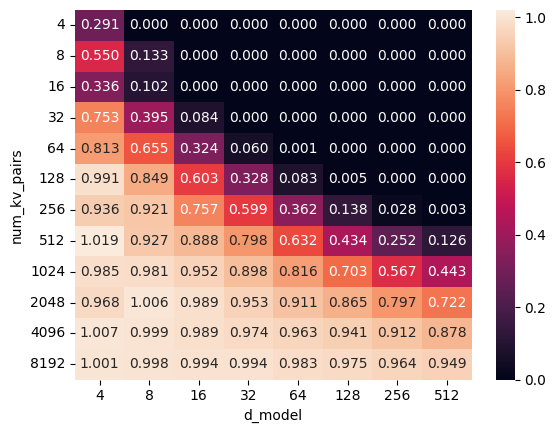

In [21]:
# Pivot the data
pivot_df = df.pivot(index='num_kv_pairs', columns='d_model', values='loss')

# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt=".3f")


<Axes: xlabel='d_model', ylabel='num_kv_pairs'>

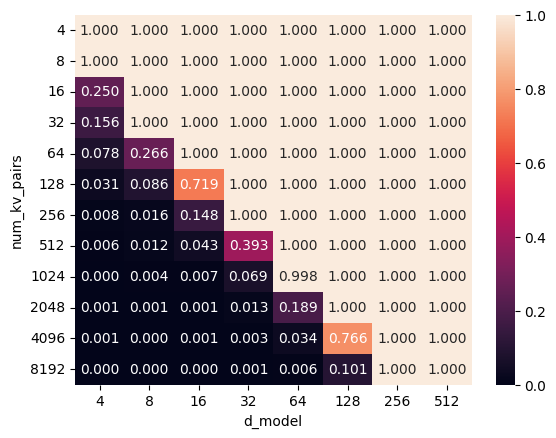

In [166]:
# Pivot the data
pivot_df = df.pivot(index='num_kv_pairs', columns='d_model', values='accuracy')

# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt=".3f")


/Users/sabrieyuboglu/opt/miniconda3/envs/zoology/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


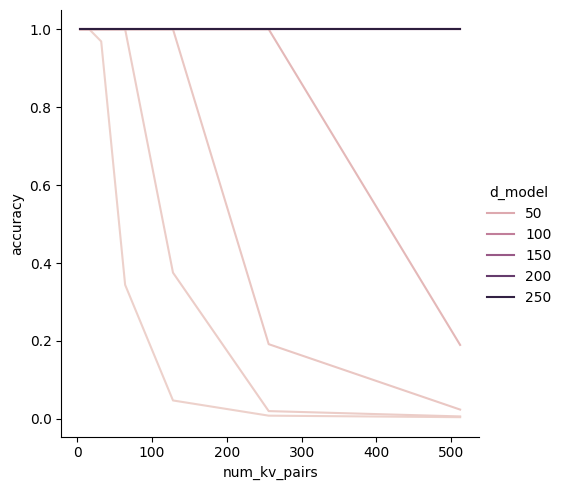

In [87]:
sns.relplot(
    data=df,
    x='num_kv_pairs',
    y='accuracy',
    hue='d_model',
    kind='line'
)

<Axes: >

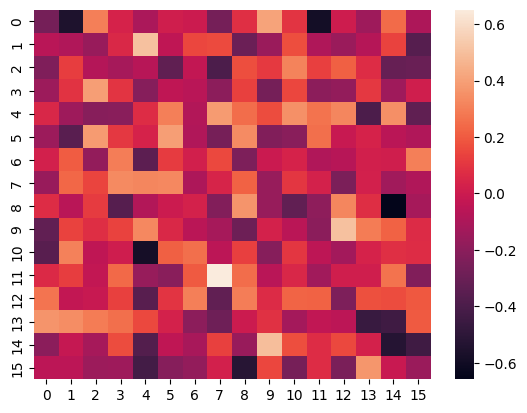

In [63]:

sns.heatmap(layer.layer.weight.detach().numpy())